# FACE Holistic Results

In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../..'))

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection
import joblib
from scripts import fit_kde
import json

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

In [4]:
RECOURSE_METHOD = 'face'
RESULTS_DIR = '../../experiment_results/face/face_holistic'

# Preliminaries -- load everything

In [5]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split="train")
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

DROP_COLUMNS = ['step_id', 'path_id', 'run_id', 'batch_id']  # columns which are convenient to drop from the path_df

with open(os.path.join(RESULTS_DIR, 'config.json')) as f:
    config_json = json.load(f)

EVAL_SPLIT = config_json['split']

EVAL_DATASET, _ = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split=EVAL_SPLIT)

config_df = pd.read_csv(os.path.join(RESULTS_DIR, 'experiment_config_df.csv'))
path_df = pd.read_csv(os.path.join(RESULTS_DIR, f'{RECOURSE_METHOD}_paths_df.csv'))
config_df

,batch_id,run_id,run_seed,confidence_cutoff,counterfactual_mode,distance_threshold,graph_directory,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds
0,396,396,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,11711,NaN,3.422047
1,390,390,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,18086,NaN,2.031773
2,648,648,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,11963,NaN,3.027345
3,958,958,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,2304,NaN,2.028696
4,655,655,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,17922,NaN,2.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,965,965,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,9695,NaN,1.977184
1134,255,255,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,6864,NaN,2.289127
1135,224,224,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,27503,NaN,2.990135
1136,1028,1028,7527,0.7,True,2.5,recourse_methods/face_graphs,50,NaN,3,12040,NaN,2.979819


## Load or Fit a KDE

In [6]:
KDE_DIRECTORY = '../../saved_models/kde/credit_card_default_kde.joblib'

if os.path.exists(KDE_DIRECTORY):
    KDE = joblib.load(KDE_DIRECTORY)
else:
    KDE = fit_kde.fit_kde('credit_card_default', KDE_DIRECTORY)

# Analyze the results

In [10]:
SPARSITY_EPSILON = 1e-5

def get_poi_cfes(path_df: pd.DataFrame):
    """Isolate the POIs (Points of Interest) and CFEs (Counterfactual Examples) from the full path results.
    
    POIs and CFEs are listed in the order they originally appear in. There is one POI and one CFE
    for every path that appears in the DataFrame."""
    pathscopy = path_df.copy()
    pathscopy['next_step_id'] = 0
    pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]
    cfes = pathscopy[pathscopy.step_id >= pathscopy.next_step_id].drop(columns='next_step_id')
    return pathscopy[pathscopy.step_id == 0].drop(columns='next_step_id'), cfes

def get_sparsity(path: pd.DataFrame):
    """Returns the maximum number of features changed in any single iteration
    along the path."""
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = (np.abs(path.iloc[i] - path.iloc[i - 1]) > SPARSITY_EPSILON).sum()
    return np.max(path_sparsity)

def get_path_length(path: pd.DataFrame):
    """Returns the sum of euclidean distances along the path."""
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path.iloc[i] - path.iloc[i - 1])
    if total == 0:
        return np.nan
    return total

def get_cfe_distance(path: pd.DataFrame):
    """Returns the euclidean distance between the first and last points in the path."""
    if len(path) == 1:
        return np.nan
    return np.linalg.norm(path.iloc[-1] - path.iloc[0])


def analyze_paths(paths: pd.DataFrame, poi_kdes, cfe_kdes, cfe_probs, config_df):
    """Returns a DataFrame containing per-path results.
    
    Each row corresponds to a specific path. Each column is a result metric.
    
    Args:
        paths: The path_df DataFrame to analyze.
        poi_kdes: The KDE scores for the POIs.
        cfe_kdes: The KDE scores for the CFEs.
        config_df: The experiment_config_df for the experiment."""
    columns = ['run_id', 'path_id', 'success', 'proximity', 'path_length',
               'iteration_count', 'poi_density', 'cfe_density', 
               'actual_sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i

    results = np.zeros((len(poi_kdes), len(columns)))

    i = 0
    for run_id in paths.run_id.unique():
        run_paths = paths[paths.run_id == run_id]
        for path_id in run_paths.path_id.unique():
            path = ADAPTER.transform(run_paths[run_paths.path_id == path_id].drop(columns=DROP_COLUMNS))
            results[i,col_idx['run_id']] = run_id
            results[i,col_idx['path_id']] = path_id

            desired_proba = config_df[config_df.run_id == run_id].confidence_cutoff.iloc[0]
            actual_proba = cfe_probs[i]

            results[i,col_idx['success']] = 1 if actual_proba >= desired_proba else 0
            results[i,col_idx['path_length']] = get_path_length(path)
            results[i,col_idx['iteration_count']] = len(path)
            results[i,col_idx['proximity']] = get_cfe_distance(path)
            results[i,col_idx['poi_density']] = poi_kdes[i]
            results[i,col_idx['cfe_density']] = cfe_kdes[i]
            results[i,col_idx['actual_sparsity']] = get_sparsity(path)
            i += 1

    return pd.DataFrame(data=results, columns=columns)

pois, cfes = get_poi_cfes(path_df)
poi_kdes = KDE.score_samples(ADAPTER.transform(pois.drop(columns=DROP_COLUMNS)))
cfe_kdes = KDE.score_samples(ADAPTER.transform(cfes.drop(columns=DROP_COLUMNS)))
cfe_probs = MODEL.predict_pos_proba(cfes.drop(columns=DROP_COLUMNS)).to_numpy()

results = analyze_paths(path_df, poi_kdes, cfe_kdes, cfe_probs, config_df)
results = results.merge(config_df, how='left', on='run_id').drop(
    columns=['max_iterations', 'noise_ratio',
             'rescale_ratio', 'run_seed',
             'counterfactual_mode', 'distance_threshold', 
             'graph_directory'])  # uninteresting columns
results

/tmp/ipykernel_1623/2243233210.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
0,396.0,0.0,0.0,NaN,NaN,1.0,-1.978000,-1.978000,NaN,396,0.7,3,11711,3.422047
1,396.0,1.0,0.0,NaN,NaN,1.0,-1.978000,-1.978000,NaN,396,0.7,3,11711,3.422047
2,396.0,2.0,0.0,NaN,NaN,1.0,-1.978000,-1.978000,NaN,396,0.7,3,11711,3.422047
3,390.0,0.0,0.0,NaN,NaN,1.0,-2.231471,-2.231471,NaN,390,0.7,3,18086,2.031773
4,390.0,1.0,0.0,NaN,NaN,1.0,-2.231471,-2.231471,NaN,390,0.7,3,18086,2.031773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,1028.0,1.0,1.0,3.956068,3.956068,2.0,0.860623,-0.666281,15.0,1028,0.7,3,12040,2.979819
3410,1028.0,2.0,1.0,3.914468,3.914468,2.0,0.860623,-0.699235,15.0,1028,0.7,3,12040,2.979819
3411,8.0,0.0,1.0,3.570458,3.570458,2.0,-0.602903,-0.699959,14.0,8,0.7,3,11223,2.885978
3412,8.0,1.0,1.0,3.638266,3.638266,2.0,-0.602903,1.647452,16.0,8,0.7,3,11223,2.885978


# Success

FACE succeeds slightly more than 50% of the time.

In [11]:
DROP_METRICS = ['actual_sparsity', 'run_id', 'batch_id', 'confidence_cutoff', 'num_paths', 'elapsed_recourse_seconds']

results.groupby('success').count()

,run_id,path_id,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
success,,,,,,,,,,,,,
0.0,1680,1680,0,0,1680,1680,1680,0,1680,1680,1680,1680,1680
1.0,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734


# Iteration count

FACE is a counterfactual method, so it either fails (count = 1) or succeeds immediately (count = 2)

In [12]:
results.groupby('iteration_count').count()

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
iteration_count,,,,,,,,,,,,,
1.0,1680,1680,1680,0,0,1680,1680,0,1680,1680,1680,1680,1680
2.0,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734,1734


# Proximity

QUESTION: Why do some points have high proximity?

<AxesSubplot: xlabel='proximity', ylabel='Count'>

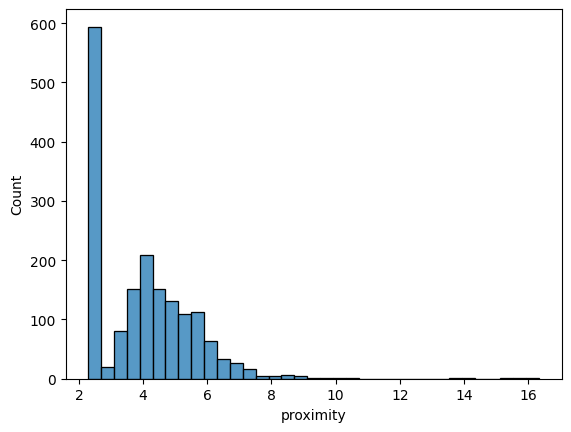

In [13]:
success_results = results[results.success == 1]
sns.histplot(success_results, x='proximity')

# Density

<AxesSubplot: xlabel='poi_density', ylabel='Count'>

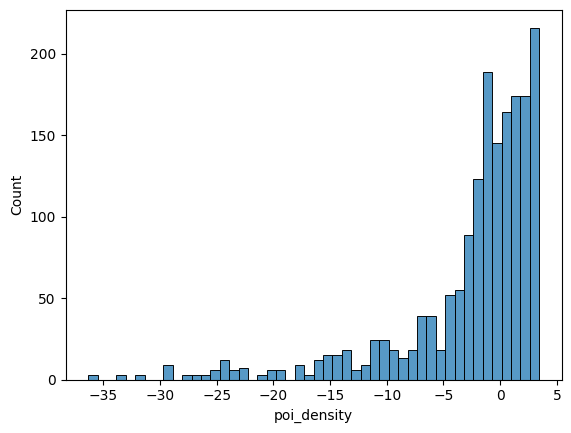

In [14]:
sns.histplot(success_results, x='poi_density')

<AxesSubplot: xlabel='cfe_density', ylabel='Count'>

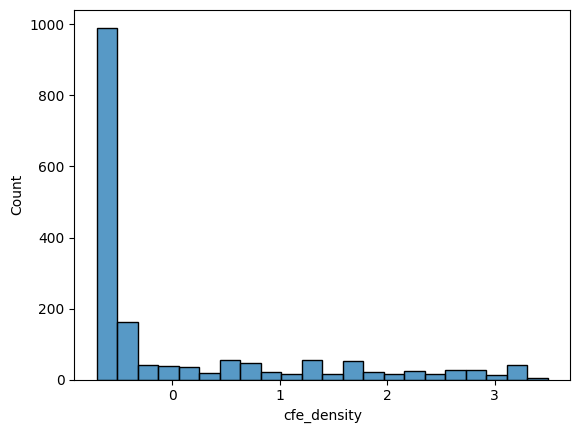

In [15]:
sns.histplot(success_results, x='cfe_density')